# Projet BIRD 

Maxime Muhlethaler & Titouan Pottier

## Import

In [12]:
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy.fftpack import fft
import numpy as np
from scipy.special import erfinv
from joblib import Parallel, delayed
import mne
import ruptures as rpt
from scipy.signal import welch
from statsmodels.tsa.stattools import adfuller

# MDCT 

## Bloc MDCT à plusieurs échelles


Dans ce bloc, on met en place une **représentation temps–fréquence** avec la **MDCT** à plusieurs échelles.  
L’idée est de projeter le signal sur un dictionnaire temps–fréquence qui servira ensuite pour le débruitage.

`framing(a, L)`

- On découpe le signal en trames de longueur $L$ avec un overlap de 50 %.  
- On obtient une matrice $L \times N_{\text{trames}}$ où chaque colonne est une trame.

`mdct(x, L)`

- On calcule la MDCT d’un signal 1D $x$ avec une fenêtre de taille $L$.  
- Chaque trame donne $K = L/2$ coefficients MDCT.  
- Au final, on obtient un grand vecteur de coefficients temps–fréquence pour cette échelle.

`get_atom(L, freq_idx)`

- On reconstruit un atome temporel associé à un indice de fréquence MDCT `freq_idx`.  
- Cet atome correspond à une colonne du dictionnaire, normalisée à $\|a\|_2 = 1$.

Classe `MDCT`

- On stocke une liste de tailles de fenêtres `scales`.  
- La méthode `doth(x)` applique la MDCT pour chaque $L$ dans `scales`.
- On obtient ainsi une représentation multi-échelle qui servira de base pour le débruitage.

In [3]:
def framing(a, L):
    shape = a.shape[:-1] + (a.shape[-1] - L + 1, L)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)[::L // 2].T.copy()

def mdct(x, L):
    x = np.array(x, dtype=float)
    N = x.size
    K = L // 2
    if N % K != 0: raise ValueError(f"Taille incorrecte: {N} n'est pas multiple de {K}")

    # Repliement
    xx = np.zeros(L // 4 + N + L // 4)
    xx[L // 4 : -L // 4] = x
    
    # Fenêtrage
    frames = framing(xx, L)
    t = np.arange(L, dtype=float)
    w = np.sin(np.pi / L * (t + 0.5))
    
    # Fenêtres de début et de fin
    w_start, w_end = w.copy(), w.copy()
    w_start[:L//4] = 0; w_start[L//4:K] = 1
    w_end[K:K+L//4] = 1; w_end[K+L//4:] = 0
    
    frames[:, 0] *= w_start
    frames[:, 1:-1] *= w[:, None]
    frames[:, -1] *= w_end

    # FFT 
    frames_c = frames.astype(complex) * np.exp(-1j * np.pi / L * t)[:, None]
    spec = fft(frames_c, axis=0)
    spec = spec[:K, :] * np.exp(-1j * np.pi * (K + 1) / L * (0.5 + t[:K]))[:, None]
    
    return math.sqrt(2. / K) * np.real(spec).ravel()

def get_atom(L, freq_idx):
    K = L / 2
    t = np.arange(L, dtype=float)
    fact = math.sqrt(2.0 / K)
    
    phase = (np.pi / K) * (freq_idx + 0.5) * ((t - K/2.0) + (L+1.0)/2.0)
    window = np.sin(np.pi / L * (t + 0.5))
    
    atom = fact * window * np.cos(phase)
    return atom / np.linalg.norm(atom)

class MDCT:
    def __init__(self, scales):
        self.scales = scales
        
    def doth(self, x):
        if x.ndim == 1:
            return np.concatenate([mdct(x, L) for L in self.scales])
        return np.array([self.doth(row) for row in x])

### Bloc BIRD


Ici, on implémente l'algorithme **BIRD** comme décrit dans le papier.

`run_bird(x, scales, lambda_stop, seed)`

- On pad le signal, on initialise un résidu et une estimation `x_est`.
- À chaque itération, pour chaque échelle $L$ dans `scales` :
  - on calcule la MDCT du résidu,
  - on empile tous les coefficients dans un grand vecteur.
- On prend le plus gros coefficient, on reconstruit l’atome associé et :
  - on l’ajoute à `x_est`,
  - on le retire du résidu.
- On met à jour un $\lambda$ basé sur la baisse de la norme du résidu et on s’arrête dès que $\lambda \le \lambda_{\text{stop}}$.

`bird(X, scales, n_runs=20, p_above=1e-7, n_jobs=1)`

- On calcule la longueur $N$ (après padding) et le nombre total de coefficients $M$ (toutes échelles, tout le temps).
- On en déduit le seuil théorique $\lambda_{\text{stop}}$ à partir de $p_{\text{above}}$ via la formule théorique du papier et redémontrée.
- Pour chaque signal / canal, on lance `run_bird` plusieurs fois avec des graines différentes, puis on moyenne toutes les estimations.
- On obtient un signal débruité, reconstruit à partir d’atomes MDCT multi-échelle, avec un critère d’arrêt sans connaître le niveau de bruit.

In [4]:
def pad_power2(X):
    n = X.shape[1]
    p = int(np.log2(n))
    pad = 2**(p+1) - n
    return np.hstack((np.zeros((X.shape[0], pad)), X)), pad

def run_bird(x, scales, lambda_stop, seed):
    rng = np.random.RandomState(seed)
    
    # Padding
    pad = int(1.5 * max(scales))
    x_work = np.concatenate((np.zeros(pad), x, np.zeros(pad)))
    n = len(x_work)
    
    # Résidu et Estimation
    residual = np.concatenate((x_work, np.zeros(max(scales)//2)))
    x_est = np.zeros(n)
    
    dico = MDCT(scales)
    total_coeffs = dico.doth(x_work).size
    coeffs_buffer = np.zeros(total_coeffs)
    
    errs = [np.linalg.norm(residual)]
    curr_lambda = 1.0
    
    for _ in range(100): 
        if curr_lambda <= lambda_stop: break
            
        # On fait une itération de BIRD
        rnd_shifts = []
        for i, L in enumerate(scales):
            shift = rng.randint(0, L//4)
            rnd_shifts.append(shift)
            coeffs_buffer[i*n : (i+1)*n] = mdct(residual[shift:shift+n], L)
            
        # Sélection du meilleur atome
        idx = np.argmax(np.abs(coeffs_buffer))
        val = coeffs_buffer[idx]
        
        # Décodage de l'indice
        s_idx = idx // n
        L = scales[s_idx]
        K = L // 2
        local_idx = idx % n
        freq = local_idx // (n // K)
        frame = local_idx % (n // K)

        # Mise à jour
        atom = get_atom(L, freq)
        pos = frame*K - L//4 + rnd_shifts[s_idx]
        
        start, end = max(0, pos), min(len(residual), pos+L)
        a_start, a_end = start-pos, start-pos+(end-start)
        
        if end > start:
            contrib = val * atom[a_start:a_end]
            residual[start:end] -= contrib
            
            est_end = min(len(x_est), end)
            if est_end > start: x_est[start:est_end] += contrib[:est_end-start]
            
        err_new = np.linalg.norm(residual)
        ratio = err_new / errs[-1]
        errs.append(err_new)
        ratio = min(1.0, ratio)
            
        curr_lambda = np.sqrt(1.0 - ratio)
        
        if curr_lambda <= lambda_stop:
            if est_end > start: x_est[start:est_end] -= contrib[:est_end-start]
            break
            
    return x_est[pad:-pad]

def bird(X, scales, n_runs=20, p_above=1e-7, n_jobs=1):
    X = np.asarray(X)
    is_1d = (X.ndim == 1)
    if is_1d: X = X[np.newaxis, :]
        
    X_pad, pad_len = pad_power2(X)
    N = float(X_pad.shape[1])
    
    # Seuil théorique
    M = np.sum(np.array(scales)//2) * N
    sigma = np.sqrt((1 - 2/np.pi) / N)
    l_stop = sigma * np.sqrt(2) * erfinv((1 - p_above)**(1/M))
    
    print(f"BIRD: Lambda={l_stop:.4f}")
    
    # Run parallèle
    seeds = np.random.randint(0, 100000, n_runs)
    denoised = np.zeros_like(X_pad)
    
    for c in range(X.shape[0]):
        res = Parallel(n_jobs=n_jobs)(delayed(run_bird)(X_pad[c], scales, l_stop, s) for s in seeds)
        denoised[c] = np.mean(res, axis=0)
        
    res = denoised[:, pad_len:]
    return res[0] if is_1d else res

### Bloc S-BIRD : débruitage multi-canaux



On implémente S-BIRD, la version multi-capteurs de BIRD. On débruite plusieurs signaux en même temps en utilisant une structure commune.

`run_sbird(X, scales, lambda_stop, p_active, seed)`

- `X` contient $n_{\text{ch}}$ canaux (lignes) et le temps (colonnes).  
- On initialise un résidu et une estimation par canal.

À chaque itération :

1. Analyse MDCT par canal 
   Pour chaque échelle $L$ :
   - on calcule la MDCT de chaque canal,
   - on stocke tous les coefficients dans `coeffs`.

2. Vote structuré
   - On regarde l’“énergie” des coefficients sur tous les canaux,
   - on garde les $n_{\text{active}} = p_{\text{active}} \cdot n_{\text{ch}}$ canaux les plus actifs,
   - on choisit l’indice avec le vote moyen maximal. Cela donne l'atome commun à activer.

3. Mise à jour par canal 
   - On reconstruit l’atome (`get_atom(L, freq)`),
   - pour chaque canal, on applique l’amplitude correspondante `amp = coeffs[c, idx]`,
   - on met à jour le résidu et l’estimation `X_est`.

4. Critère d’arrêt commun 
   - On calcule un $\lambda$ par canal à partir de la baisse de norme du résidu,
   - on moyenne les plus grands $\lambda$ (les canaux actifs),
   - si $\lambda \le \lambda_{\text{stop}}$, on s’arrête.

`sbird(X, scales, n_runs=20, p_above=1e-7, p_active=1.0, n_jobs=1)`

- On pad les signaux à une longueur puissance de 2 (comme pour BIRD).  
- On calcule le seuil théorique $\lambda_{\text{stop}}$ à partir de $N$ et du nombre total de coefficients $M$.  
- On lance `run_sbird` plusieurs fois avec des graines différentes, puis on moyenne les résultats.  

Au final, on obtient un débruitage multi-canaux, où les atomes sont sélectionnés en fonction de ce qui est cohérent à travers les capteurs.

In [ ]:
def run_sbird(X, scales, lambda_stop, p_active, seed):
    rng = np.random.RandomState(seed)
    n_ch, _ = X.shape
    n_active = max(1, int(n_ch * p_active))
    
    pad = int(1.5 * max(scales))
    X_work = np.pad(X, ((0,0), (pad, pad)), mode='constant')
    n = X_work.shape[1]
    
    residual = np.hstack((X_work, np.zeros((n_ch, max(scales)//2))))
    X_est = np.zeros_like(X_work)
    
    # Dictionnaire
    dico = MDCT(scales)
    n_projs = dico.doth(X_work).shape[1]
    coeffs = np.zeros((n_ch, n_projs))
    
    errs = {c: [np.linalg.norm(residual[c])] for c in range(n_ch)}
    curr_lambda = 1.0
    
    for _ in range(100):
        if curr_lambda <= lambda_stop: break
            
        # Calcul des coefficients MDCT avec shifts aléatoires
        rnd_shifts = {c: [] for c in range(n_ch)}
        for i, L in enumerate(scales):
            shift = rng.randint(0, L//4)
            for c in range(n_ch):
                coeffs[c, i*n:(i+1)*n] = mdct(residual[c, shift:shift+n], L)
                rnd_shifts[c].append(shift)
                
        #  Vote Structuré 
        energies = np.sort((coeffs**2)**2, axis=0) 
        votes = np.mean(energies[-n_active:], axis=0)
        idx = np.argmax(votes)
        
        # Décodage
        s_idx = idx // n
        L = scales[s_idx]
        K = L // 2
        local = idx % n
        freq = local // (n//K)
        frame = local % (n//K)
        
        atom = get_atom(L, freq)
        lambdas_step = []
        
        # Update par canal
        for c in range(n_ch):
            amp = coeffs[c, idx]
            shift = rnd_shifts[c][s_idx]
            pos = frame*K - L//4 + shift
            
            start, end = max(0, pos), min(residual.shape[1], pos+L)
            a_start, a_end = start-pos, start-pos+(end-start)
            
            if end > start:
                contrib = amp * atom[a_start:a_end]
                residual[c, start:end] -= contrib
                
                est_end = min(X_est.shape[1], end)
                if est_end > start: X_est[c, start:est_end] += contrib[:est_end-start]
                
            err_new = np.linalg.norm(residual[c])
            ratio = err_new / errs[c][-1]
            errs[c].append(err_new)
            
            if ratio < 1.0:
                lambdas_step.append(np.sqrt(1.0 - ratio))
            else:
                lambdas_step.append(0.0) 
                
        # Moyenne des lambdas
        lambdas_step.sort()
        curr_lambda = np.mean(lambdas_step[-n_active:])
        
    return X_est[:, pad:-pad]

def sbird(X, scales, n_runs=20, p_above=1e-7, p_active=1.0, n_jobs=1):
    X_pad, pad_len = pad_power2(np.asarray(X))
    N = float(X_pad.shape[1])
    
    # Seuil
    M = np.sum(np.array(scales)//2) * N
    sigma = np.sqrt((1 - 2/np.pi) / N)
    l_stop = sigma * np.sqrt(2) * erfinv((1 - p_above)**(1/M))
    
    print(f"S-BIRD: Lambda={l_stop:.4f}")
    
    seeds = np.random.randint(0, 100000, n_runs)
    res = Parallel(n_jobs=n_jobs)(delayed(run_sbird)(X_pad, scales, l_stop, p_active, s) for s in seeds)
    
    denoised = np.mean(res, axis=0)
    return denoised[:, pad_len:]

# Baselines

In [6]:
from scipy.fft import rfft, irfft
import pywt

def wiener_denoise(y, sigma):
    """
    Wiener filter simple en domaine fréquentiel.
    sigma : écart-type du bruit
    """
    Y = rfft(y)
    Pyy = np.abs(Y)**2
    Pnn = sigma**2
    H = np.maximum(Pyy - Pnn, 0) / (Pyy + 1e-12)
    Xhat = H * Y
    return irfft(Xhat, n=len(y))


def wavelet_denoise(y, wavelet="db8"):
    coeffs = pywt.wavedec(y, wavelet, level=None)
    
    # estimation sigma bruit (MAD)
    sigma_hat = np.median(np.abs(coeffs[-1])) / 0.6745
    thresh = sigma_hat * np.sqrt(2 * np.log(len(y)))

    coeffs_thresh = [coeffs[0]]
    for c in coeffs[1:]:
        coeffs_thresh.append(pywt.threshold(c, thresh, mode="soft"))

    return pywt.waverec(coeffs_thresh, wavelet)[:len(y)]



# Expériences

## Données MEG réelles (Dataset Somato)

Pour cette expérience, nous utilisons le jeu de données somato de la librairie MNE. Il s'agit d'enregistrements MEG capturant la réponse cérébrale à une stimulation du nerf médian.

Nous sélectionnons 10 gradiomètres voisins situés dans la zone d'activité et extrayons une fenêtre de 1 seconde. Le signal est filtré entre 1 et 40 Hz.

L'approche est semi-synthétique pour permettre le calcul de l'erreur (MSE) :
* Le signal réel filtré est considéré comme la Vérité Terrain $X_{clean}$.
* Nous ajoutons un bruit blanc gaussien pour obtenir le signal observé $X_{noisy}$, avec un rapport signal-sur-bruit (SNR) de 5 dB.

In [ ]:
np.random.seed(42)

# Chargement et prétraitement MEG (Somato)
data_path = mne.datasets.somato.data_path()
raw_fname = data_path / "sub-01" / "meg" / "sub-01_task-somato_meg.fif"
raw = mne.io.read_raw_fif(raw_fname, preload=True, verbose=False)

# Détection des événements
events = mne.find_events(raw, verbose=False)
event_id = 1
onset = events[events[:, 2] == event_id, 0][0] / raw.info["sfreq"]

# Prétraitement
raw.pick_types(meg="grad", eeg=False, eog=False, stim=False)
raw.filter(1, 40, verbose=False)

# Fenêtre temporelle autour du stimulus
tmin, tmax = onset - 0.2, onset + 0.8
raw_crop = raw.copy().crop(tmin=tmin, tmax=tmax)

# Sélection des 10 canaux autour du pic d'activité
data_temp = raw_crop.get_data()
peak_idx = np.argmax(np.std(data_temp, axis=1))
roi_channels = range(peak_idx - 5, peak_idx + 5)
X_clean = raw_crop.get_data()[roi_channels, :] * 1e13
n_channels, n_times = X_clean.shape
times = raw_crop.times

print(f"Données MEG (Somato) : {n_channels} canaux, {n_times} temps")
print(f"Canal pic détecté : {peak_idx}")

# Canal central pour l'analyse mono-canal
y_clean = X_clean[5]

# Ajout de bruit artificiel
SNR_target = 5.0
sigma_s = np.linalg.norm(X_clean) / np.sqrt(n_channels * n_times)
sigma_n = sigma_s * (10 ** (-SNR_target / 20.0))
noise = np.random.randn(n_channels, n_times) * sigma_n
X_noisy = X_clean + noise
y_noisy = X_noisy[5]

### On commence par une analyse fine du dataset !

Analyse lancée sur le canal 0


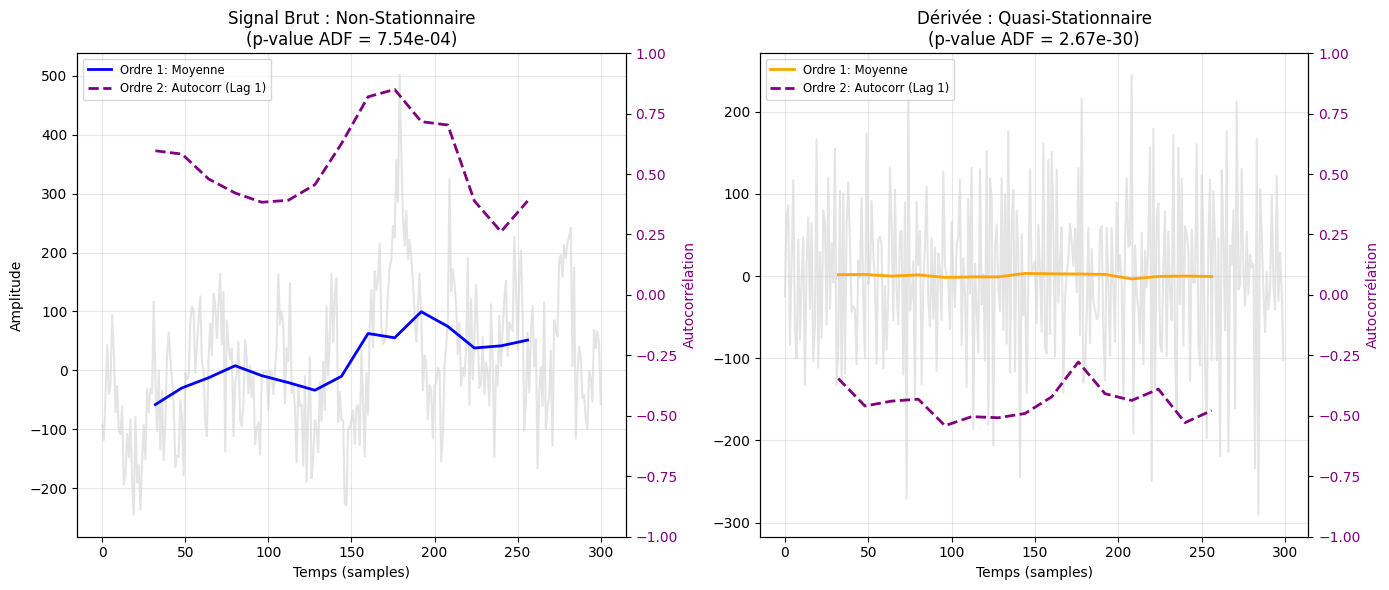

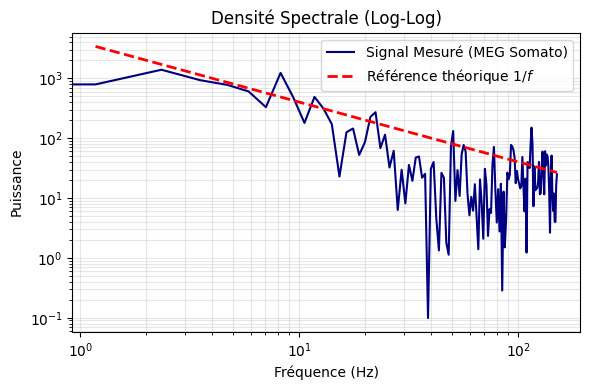

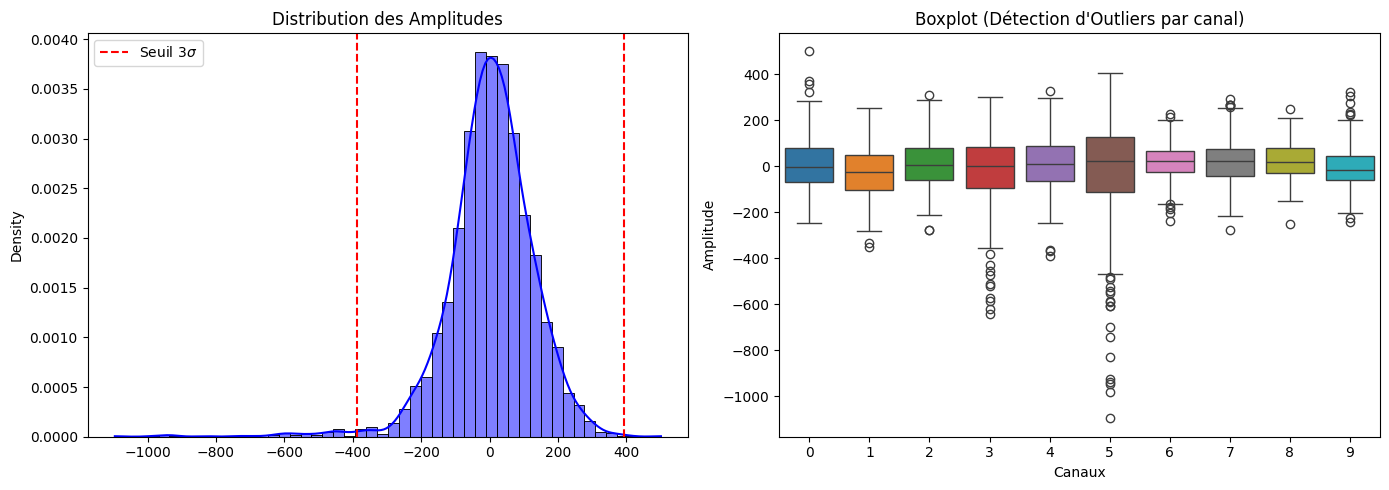

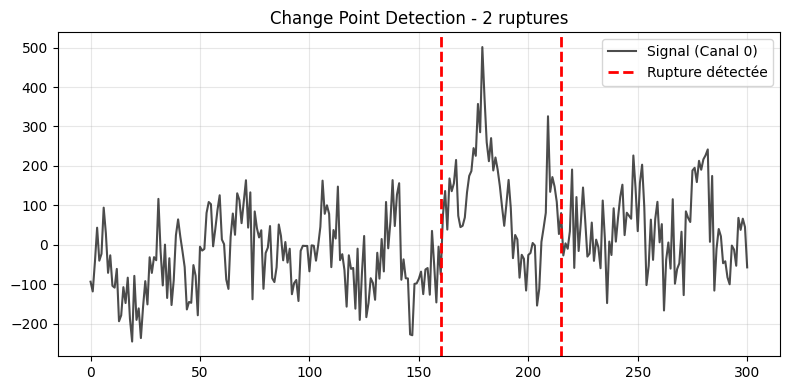

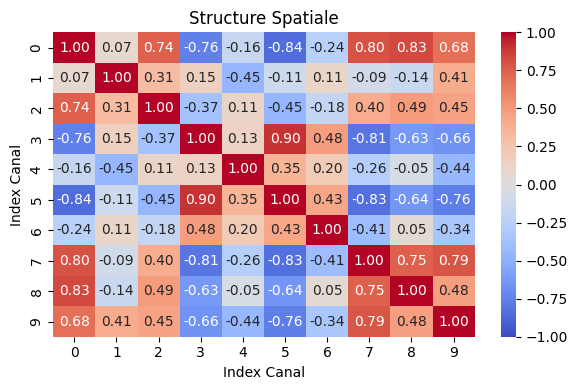

In [ ]:
X_analysed = X_noisy 
n_channels, n_times = X_analysed.shape
fs = raw.info['sfreq'] 
window_size = 64
channel_idx = 0

print(f"Analyse lancée sur le canal {channel_idx}")

# FONCTION UTILITAIRE
def get_rolling_stationarity_stats(sig, w):
    n_points = len(sig)
    means = []
    autocorrs = []
    t_axis = []
    step = w // 4 
    for i in range(0, n_points - w, step):
        segment = sig[i : i+w]
        means.append(np.mean(segment))
        if np.std(segment) > 1e-12:
            ac = np.corrcoef(segment[:-1], segment[1:])[0, 1]
        else:
            ac = 0
        autocorrs.append(ac)
        t_axis.append(i + w/2)
    return np.array(t_axis), np.array(means), np.array(autocorrs)

# STATIONNARITÉ
plt.figure(figsize=(14, 6))
ax1 = plt.subplot(1, 2, 1)
sig0 = X_analysed[channel_idx, :]
t_bins0, mean0, ac0 = get_rolling_stationarity_stats(sig0, window_size)
adf0 = adfuller(sig0)

ax1.plot(sig0, color='lightgrey', label='Signal Brut', alpha=0.6)
l1, = ax1.plot(t_bins0, mean0, color='blue', linewidth=2, label='Ordre 1: Moyenne')
ax1.set_ylabel("Amplitude")
ax1.set_xlabel("Temps (samples)")

ax1_twin = ax1.twinx()
l2, = ax1_twin.plot(t_bins0, ac0, color='purple', linestyle='--', linewidth=2, label='Ordre 2: Autocorr (Lag 1)')
ax1_twin.set_ylabel("Autocorrélation", color='purple')
ax1_twin.set_ylim(-1, 1)
ax1_twin.tick_params(axis='y', labelcolor='purple')

ax1.set_title(f"Signal Brut : Non-Stationnaire\n(p-value ADF = {adf0[1]:.2e})")
lines = [l1, l2]
ax1.legend(lines, [l.get_label() for l in lines], loc='upper left', fontsize='small')
ax1.grid(alpha=0.3)

# Ordre 1 : Signal Différencié
ax2 = plt.subplot(1, 2, 2)
sig1 = np.diff(sig0, n=1)
t_bins1, mean1, ac1 = get_rolling_stationarity_stats(sig1, window_size)
adf1 = adfuller(sig1)

ax2.plot(sig1, color='lightgrey', label='Dérivée 1ère', alpha=0.6)
l1, = ax2.plot(t_bins1, mean1, color='orange', linewidth=2, label='Ordre 1: Moyenne')
ax2.set_xlabel("Temps (samples)")

ax2_twin = ax2.twinx()
l2, = ax2_twin.plot(t_bins1, ac1, color='purple', linestyle='--', linewidth=2, label='Ordre 2: Autocorr (Lag 1)')
ax2_twin.set_ylabel("Autocorrélation", color='purple')
ax2_twin.set_ylim(-1, 1)
ax2_twin.tick_params(axis='y', labelcolor='purple')

ax2.set_title(f"Dérivée : Quasi-Stationnaire\n(p-value ADF = {adf1[1]:.2e})")
lines = [l1, l2]
ax2.legend(lines, [l.get_label() for l in lines], loc='upper left', fontsize='small')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()



# ANALYSE SPECTRALE (PSD)
plt.figure(figsize=(6, 4))

freqs, psd = welch(X_analysed[channel_idx], fs=fs, nperseg=256)

freqs_log = freqs[1:] 
psd_log = psd[1:]
ref_idx = 10
constante = psd_log[ref_idx] * freqs_log[ref_idx]
theoretical_1f = constante / freqs_log

plt.loglog(freqs, psd, color='navy', linewidth=1.5, label='Signal Mesuré (MEG Somato)')
plt.loglog(freqs_log, theoretical_1f, color='red', linestyle='--', linewidth=2, label=r'Référence théorique $1/f$')

plt.title("Densité Spectrale (Log-Log)")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Puissance")
plt.legend()
plt.grid(True, which="both", alpha=0.3) 

plt.tight_layout()
plt.show()


# DISTRIBUTION & OUTLIERS

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
# Histogramme global
sns.histplot(X_analysed.flatten(), bins=50, kde=True, color='blue', stat="density")
sigma = np.std(X_analysed)
mu = np.mean(X_analysed)
plt.axvline(mu + 3*sigma, color='r', linestyle='--', label=r'Seuil 3$\sigma$')
plt.axvline(mu - 3*sigma, color='r', linestyle='--')
plt.title("Distribution des Amplitudes")
plt.legend()

plt.subplot(1, 2, 2)
# Boxplot global
sns.boxplot(data=X_analysed.T) 
plt.title("Boxplot (Détection d'Outliers par canal)")
plt.xlabel("Canaux")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()



# DÉTECTION DE RUPTURES

plt.figure(figsize=(8, 4))

sig_to_test = X_analysed[channel_idx]
sig_norm = (sig_to_test - np.mean(sig_to_test)) / np.std(sig_to_test)
algo = rpt.Pelt(model="l2", min_size=50).fit(sig_norm)
result_bkps = algo.predict(pen=12)
plt.plot(sig_to_test, color='k', alpha=0.7, label=f'Signal (Canal {channel_idx})')
for bkp in result_bkps[:-1]:
    plt.axvline(x=bkp, color='r', linestyle='--', linewidth=2, label='Rupture détectée' if bkp == result_bkps[0] else "")

plt.title(f"Change Point Detection - {len(result_bkps)-1} ruptures")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# CORRÉLATION SPATIALE
plt.figure(figsize=(6, 4))

data_to_corr = X_clean
corr_matrix = np.corrcoef(data_to_corr)

sns.heatmap(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1, annot=True, fmt=".2f")
plt.title("Structure Spatiale")
plt.xlabel("Index Canal")
plt.ylabel("Index Canal")

plt.tight_layout()
plt.show()

### On procède aux expériences 1 et 2 sur les données. 

On teste :
- nos bsalines
- BIRD sur un seul canal 
- S-BIRD sur les 10 canaux en même temps  

On compare la MSE et les courbes temporelles sur le canal 0 (signal propre, BIRD, S-BIRD, et un zoom autour d’un pic d’activité) et on regarge surtout l'influence de `p_active` pour S-BIRD.

BIRD
BIRD: Lambda=0.1544
S-BIRD multi-canaux, p_active=0.8
S-BIRD: Lambda=0.1544
S-BIRD multi-canaux, p_active=0.1
S-BIRD: Lambda=0.1544
MSE Wiener        : 4.05e+03 (Gain : +0.02 dB)
MSE Wavelet       : 4.01e+03 (Gain : +0.06 dB)
MSE bruité        : 4.07e+03
MSE BIRD          : 1.30e+03  (Gain : +4.95 dB)
MSE S-BIRD p=0.8  : 9.29e+03 (Gain : +-3.58 dB)
MSE S-BIRD p=0.1  : 1.04e+03 (Gain : +5.91 dB)


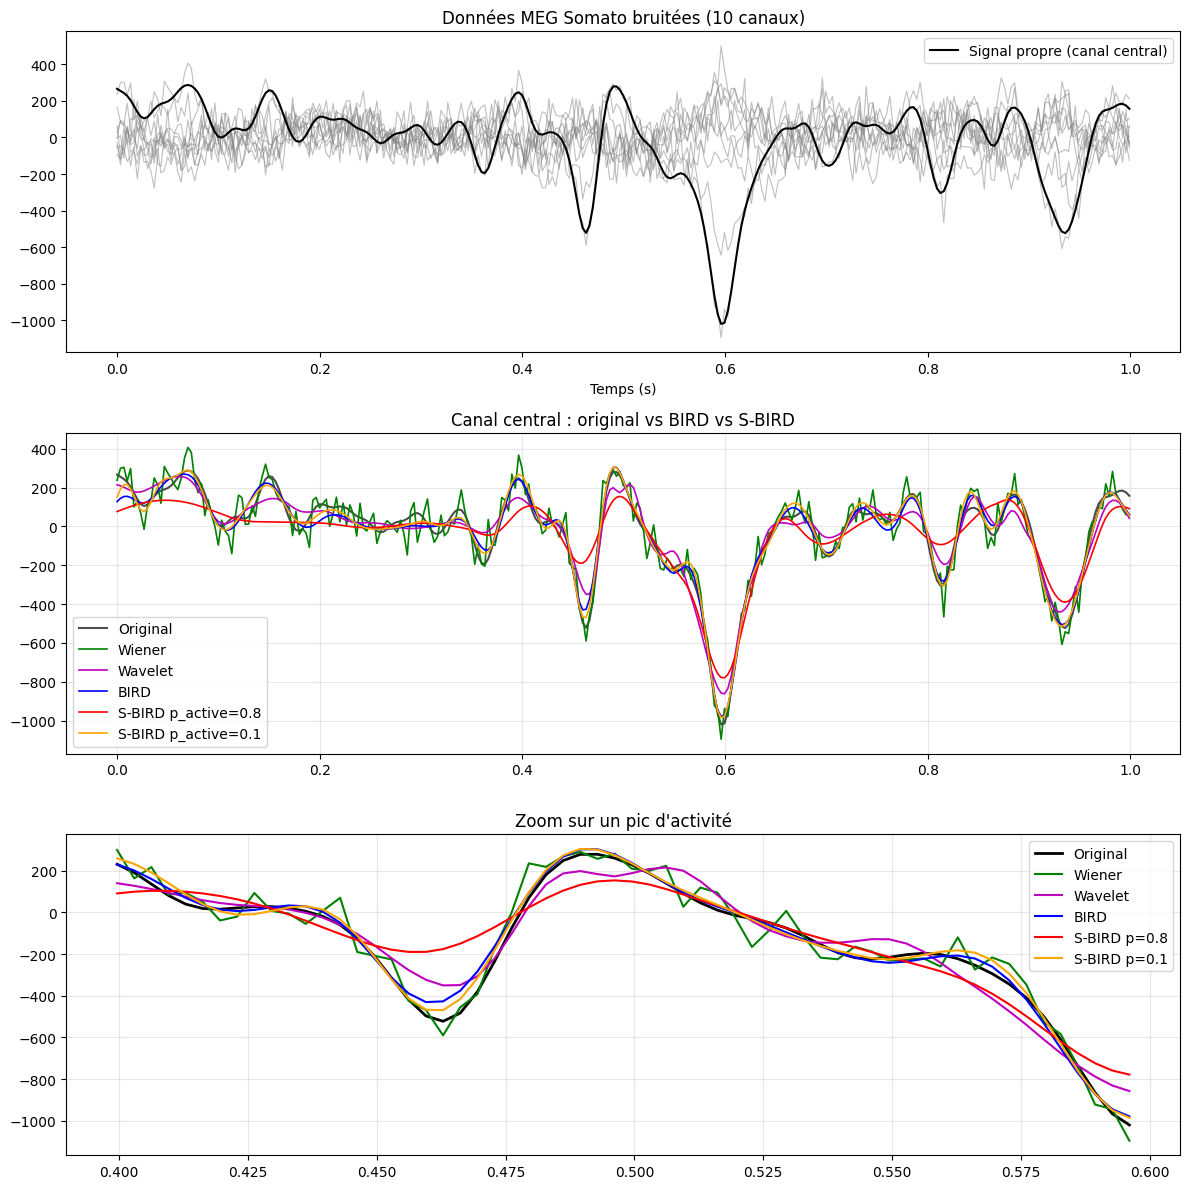

In [21]:
# Baselines : Wiener et ondelettes
sigma_noise = sigma_n  # connu ici
denoised_wiener = wiener_denoise(y_noisy, sigma_noise)
denoised_wavelet = wavelet_denoise(y_noisy)


# Paramètres BIRD / S-BIRD
scales = [32, 64, 128, 256]
n_runs = 30
M = len(scales) * n_times
p_above = 1.0 / M

# BIRD mono-canal
print("BIRD")
denoised_bird = bird(
    y_noisy,
    scales=scales,
    n_runs=n_runs,
    p_above=p_above,
)

# S-BIRD multi-canaux et on teste deux p_active
p_list = [0.8, 0.1]
denoised_sbird = {}

for p_active in p_list:
    print(f"S-BIRD multi-canaux, p_active={p_active}")
    den_all = sbird(
        X_noisy,
        scales=scales,
        n_runs=n_runs,
        p_active=p_active,
        p_above=p_above,
    )
    denoised_sbird[p_active] = den_all[5]  # canal central

# MSE et gains
mse_raw = np.mean((y_clean - y_noisy) ** 2)
mse_bird = np.mean((y_clean - denoised_bird) ** 2)
mse_sbird_08 = np.mean((y_clean - denoised_sbird[0.8]) ** 2)
mse_sbird_01 = np.mean((y_clean - denoised_sbird[0.1]) ** 2)
mse_wiener = np.mean((y_clean - denoised_wiener) ** 2)
mse_wavelet = np.mean((y_clean - denoised_wavelet) ** 2)

def gain_db(mse):
    return 10 * np.log10(mse_raw / mse)

print(f"MSE Wiener        : {mse_wiener:.2e} (Gain : +{gain_db(mse_wiener):.2f} dB)")
print(f"MSE Wavelet       : {mse_wavelet:.2e} (Gain : +{gain_db(mse_wavelet):.2f} dB)")
print(f"MSE bruité        : {mse_raw:.2e}")
print(f"MSE BIRD          : {mse_bird:.2e}  (Gain : +{gain_db(mse_bird):.2f} dB)")
print(f"MSE S-BIRD p=0.8  : {mse_sbird_08:.2e} (Gain : +{gain_db(mse_sbird_08):.2f} dB)")
print(f"MSE S-BIRD p=0.1  : {mse_sbird_01:.2e} (Gain : +{gain_db(mse_sbird_01):.2f} dB)")

# PLots
plt.figure(figsize=(12, 12))


plt.subplot(3, 1, 1)
plt.title("Données MEG Somato bruitées (10 canaux)")
plt.plot(times, X_noisy.T, color="grey", alpha=0.5, linewidth=0.8)
plt.plot(times, y_clean, "k", linewidth=1.5, label="Signal propre (canal central)")
plt.xlabel("Temps (s)")
plt.legend()

plt.subplot(3, 1, 2)
plt.title("Canal central : original vs BIRD vs S-BIRD")
plt.plot(times, y_clean, "k", lw=1.5, alpha=0.7, label="Original")
plt.plot(times, denoised_wiener, "g", lw=1.2, label="Wiener")
plt.plot(times, denoised_wavelet, "m", lw=1.2, label="Wavelet")
plt.plot(times, denoised_bird, "b", lw=1.2, label="BIRD")
plt.plot(times, denoised_sbird[0.8], "r", lw=1.2, label="S-BIRD p_active=0.8")
plt.plot(times, denoised_sbird[0.1], "orange", lw=1.2, label="S-BIRD p_active=0.1")
plt.grid(alpha=0.3)
plt.legend()

# Zoom 
plt.subplot(3, 1, 3)
plt.title("Zoom sur un pic d'activité")
mid = n_times // 2
zoom = slice(mid - 30, mid + 30)
plt.plot(times[zoom], y_clean[zoom], "k", lw=2, label="Original")
plt.plot(times[zoom], denoised_wiener[zoom], "g", lw=1.5, label="Wiener")
plt.plot(times[zoom], denoised_wavelet[zoom], "m", lw=1.5, label="Wavelet")
plt.plot(times[zoom], denoised_bird[zoom], "b", lw=1.5, label="BIRD")
plt.plot(times[zoom], denoised_sbird[0.8][zoom], "r", lw=1.5, label="S-BIRD p=0.8")
plt.plot(times[zoom], denoised_sbird[0.1][zoom], "orange", lw=1.5, label="S-BIRD p=0.1")
plt.grid(alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()


#### Analyse des résultats et rôle de `p_active`

Quand `p_active` est élevé (par exemple \(0.8\)), S-BIRD demande qu’un atome soit fort sur la majorité des capteurs pour être accepté. C’est une logique de vote massif.

Mais une source MEG est souvent locale : le champ magnétique forme un dipôle, fort sur quelques capteurs, faible ou presque nul sur les voisins.

Avec un `p_active` trop grand, les atomes forts sur 1 ou 2 capteurs sont souvent rejetés et l’algorithme prend ces pics locaux pour du bruit. Ainsi, le résultat est trop lissé !!

En baissant `p_active` (par exemple à \(0.1\)) : on autorise S-BIRD à valider un atome dès qu’il est clairement présent sur au moins un capteur. Ainsi, les sources localisées sont mieux capturées et on suit mieux la forme des pics sans tuer les détails

Dans ce cas, l’algorithme devient plus intelligent : il comprend qu’un signal net et bien structuré sur un capteur isolé a peu de chances d’être du simple bruit aléatoire. Il décide donc de faire confiance à ce capteur, tout en nettoyant le reste grâce au dictionnaire !! 

C’est donc un compromis entre sécurité vs sensibilité :
- Si `p_active` haut, on est très sûr contre les artefacts d’un seul capteur,  mais risque de supprimer un vrai signal local.  
- Si `p_active` bas, on sauve les signaux locaux,  mais on accepte le risque de conserver un artefact isolé.

Il n’y a pas de valeur universel de \(p\). On doit s’appuyer sur la physique de l’expérience !!
En MEG, on sait que les sources sont souvent très locales donc on préfère baisser \(p\) et accepter quelques artefacts plutôt que rater un vrai signal biologique bien localisé.

Text(0.5, 0, 'Temps (s)')

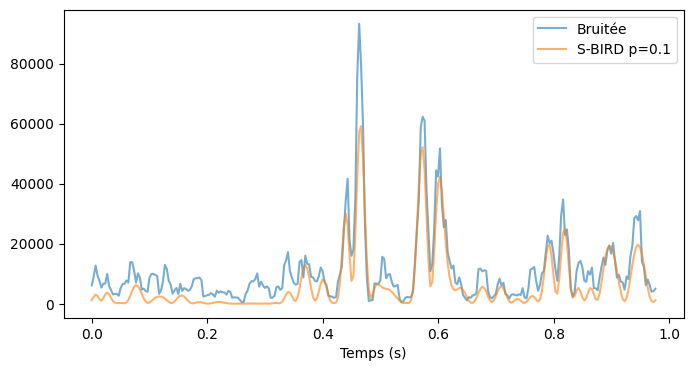

In [22]:
def sliding_variance(x, win):
    return np.array([
        np.var(x[i:i+win])
        for i in range(len(x) - win)
    ])
fs = 150
win = int(0.05 * fs)

var_noisy = sliding_variance(y_noisy, win)
var_sbird = sliding_variance(denoised_sbird[0.1], win)
plt.figure(figsize=(8,4))
plt.plot(times[:-win], var_noisy, label="Bruitée", alpha=0.6)
plt.plot(times[:-win], var_sbird, label="S-BIRD p=0.1", alpha=0.6)
plt.legend()
plt.xlabel("Temps (s)")

## Expérience 3 : bursts cachés et rôle de `p_above`


On construit un signal synthétique avec trois bursts bien séparés. On duplique ce signal sur 8 canaux et on ajoute un bruit blanc très fort. (SNR = −2 dB, le bruit est plus fort que le signal).

On applique ensuite :
- BIRD sur le canal 0  
- S-BIRD sur les 8 canaux

On teste deux valeurs de `p_above` :
- `p_above = 0.02` : critère permissif, l’algorithme va loin dans les itérations  
- `p_above = 2e-10` : critère très strict, l’algorithme s’arrête tôt

On trace le signal bruité, la vérité et les sorties BIRD / S-BIRD pour les deux cas.

SNR = -2 dB, 8 canaux

 p_above = 0.02
BIRD: Lambda=0.0516
S-BIRD: Lambda=0.0516
MSE BIRD   : 0.0028
MSE S-BIRD : 0.0002

 p_above = 2e-10
BIRD: Lambda=0.0765
S-BIRD: Lambda=0.0765
MSE BIRD   : 0.0006
MSE S-BIRD : 0.0003


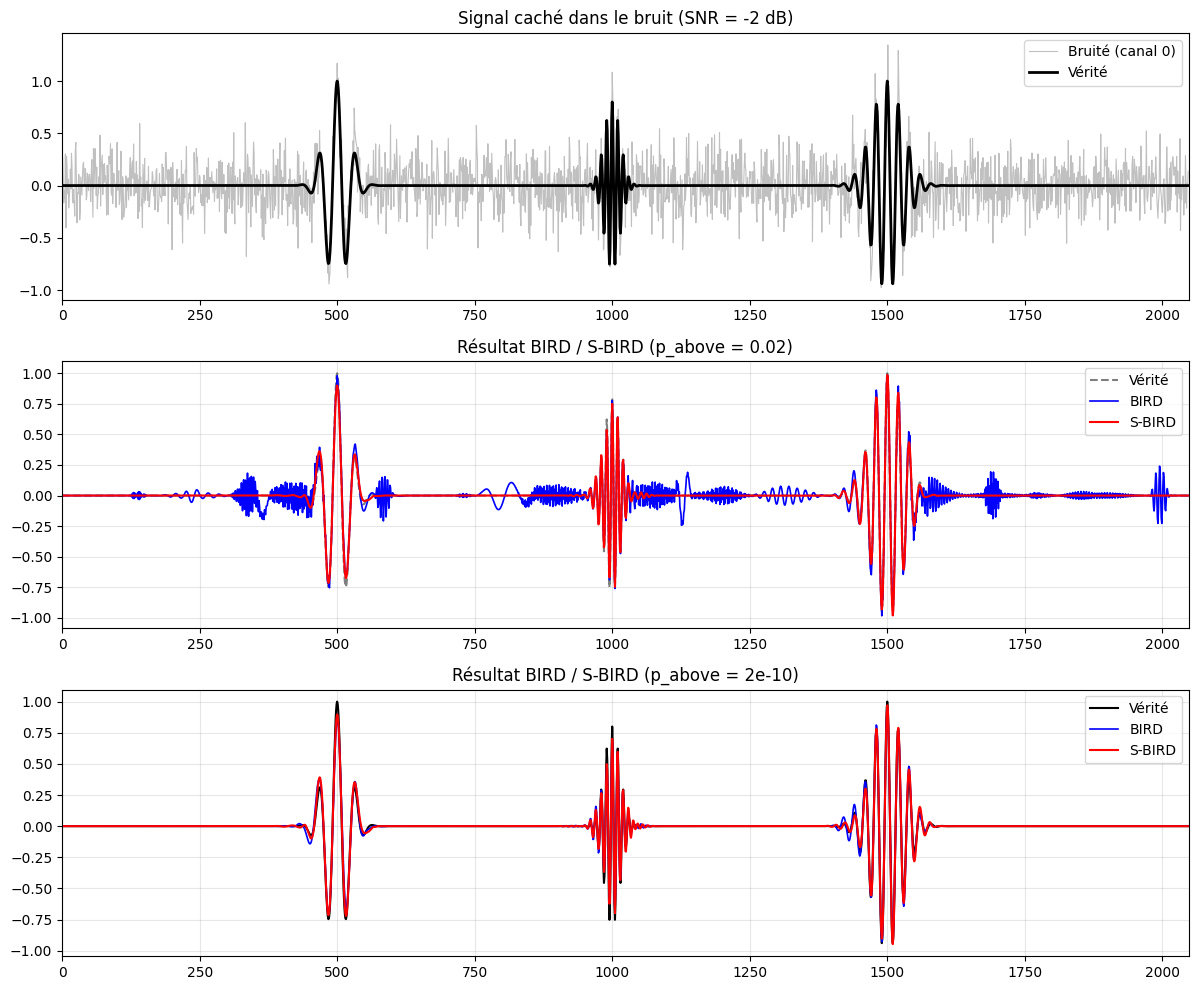

In [ ]:
# Signal de test : 3 bursts
def make_bursts(N):
    t = np.arange(N)
    sig = np.zeros(N)
    sig += 5.0 * np.exp(-((t - 500)/30)**2)  * np.cos(2*np.pi*0.03*t)
    sig += 4.0 * np.exp(-((t - 1000)/20)**2) * np.cos(2*np.pi*0.10*t)
    sig += 5.0 * np.exp(-((t - 1500)/40)**2) * np.cos(2*np.pi*0.05*t)
    return sig / np.max(np.abs(sig))

N = 2048
n_channels = 8
scales = [32, 64, 128]
n_runs = 40

clean_sig = make_bursts(N)
X_clean = np.tile(clean_sig, (n_channels, 1))

# Bruit très fort (SNR négatif)
np.random.seed(999)
SNR = -2
sigma = np.linalg.norm(clean_sig) * 10**(-SNR / 20.0)

noise = np.random.randn(n_channels, N)
X_noise = (noise.T / np.linalg.norm(noise, axis=1) * sigma).T
X_noisy = X_clean + X_noise

print(f"SNR = {SNR} dB, 8 canaux")

# On teste deux valeurs de p_above
p_values = [0.02, 2e-10]
results = {}

for p_above in p_values:
    print(f"\n p_above = {p_above}")
    # BIRD sur le canal 0
    den_bird = bird(X_noisy[0], scales=scales, n_runs=n_runs, p_above=p_above)
    # S-BIRD sur les 8 canaux
    den_sbird_all = sbird(
        X_noisy,
        scales=scales,
        n_runs=n_runs,
        p_active=1.0,
        p_above=p_above,
    )
    den_sbird = den_sbird_all[0]

    mse_bird = np.mean((clean_sig - den_bird)**2)
    mse_sbird = np.mean((clean_sig - den_sbird)**2)
    results[p_above] = (den_bird, den_sbird, mse_bird, mse_sbird)

    print(f"MSE BIRD   : {mse_bird:.4f}")
    print(f"MSE S-BIRD : {mse_sbird:.4f}")

# 4) Tracés
plt.figure(figsize=(12, 10))

# signal bruité vs vérité
plt.subplot(3, 1, 1)
plt.title(f"Signal caché dans le bruit (SNR = {SNR} dB)")
plt.plot(X_noisy[0], "silver", lw=0.8, label="Bruité (canal 0)")
plt.plot(clean_sig, "k", lw=2, label="Vérité")
plt.legend()
plt.xlim(0, N)

# cas p_above = 0.02
plt.subplot(3, 1, 2)
p = p_values[0]
den_bird, den_sbird, _, _ = results[p]
plt.title(f"Résultat BIRD / S-BIRD (p_above = {p})")
plt.plot(clean_sig, "k--", alpha=0.5, label="Vérité")
plt.plot(den_bird, "b", lw=1.2, label="BIRD")
plt.plot(den_sbird, "r", lw=1.5, label="S-BIRD")
plt.legend()
plt.grid(alpha=0.3)
plt.xlim(0, N)

# cas p_above = 2e-10
plt.subplot(3, 1, 3)
p = p_values[1]
den_bird, den_sbird, _, _ = results[p]
plt.title(f"Résultat BIRD / S-BIRD (p_above = {p})")
plt.plot(clean_sig, "k", alpha=1, label="Vérité")
plt.plot(den_bird, "b", lw=1.2, label="BIRD")
plt.plot(den_sbird, "r", lw=1.5, label="S-BIRD")
plt.legend()
plt.grid(alpha=0.3)
plt.xlim(0, N)

plt.tight_layout()
plt.show()

### effet de `p_above` sur BIRD et S-BIRD

`p_above` contrôle jusqu’où on autorise l’algorithme à creuser dans le bruit.

- Avec `p_above = 0.02` :  
  - BIRD travaille en solo sur un capteur. Il prend facilement des gros pics de bruit pour du signal et rajoute des bursts qui n’existent pas.  
  - S-BIRD regarde les 8 canaux. Le vrai burst est présent sur tous les canaux, le bruit ne l’est pas car mais il est indépendant d’un canal à l’autre. C’est ça qui donne l’avantage à S-BIRD :
    le vrai burst est aligné sur tous les canaux, alors que les gros pics de bruit n’arrivent pas au même endroit sur les 8 en même temps (ou très rarement).
    S-BIRD reconstruit donc beaucoup mieux la forme des bursts.

- Avec `p_above = 2e-10` :  
  - Le seuil devient beaucoup plus strict.  
  - BIRD lisse beaucoup mieux le signal 
  - S-BIRD reste un peu plus robuste, il reste un tout petit peu plus précis en exploitant l'information de tous les canaux !!

On voit donc deux choses :

1. Un `p_above` trop grand peut faire sur-apprendre le bruit, surtout pour BIRD.  
2. Un `p_above` trop petit peut couper de l'information.

BIRD est un nettoyeur polyvalent qui traite chaque canal isolément, tandis que S-BIRD est un nettoyeur intelligent qui exploite la redondance entre les capteurs pour écraser le bruit massif, à condition que le signal soit physiquement cohérent spatialement !! C'est ce qu'on va mettre en lumière dans la suite.

## Expérience 4 : signaux désynchronisés



Dans cette expérience, on simule une petite onde qui se propage avec un retard fixe sur 5 capteurs. Le même pulse arrive d’abord sur le canal 0, puis 50 samples plus tard sur le canal 1, etc.  

On ajoute un bruit blanc gaussien pour obtenir un SNR modéré.  
On applique ensuite :

- BIRD sur tous les canaux, mais de façon indépendante (canal par canal)  
- S-BIRD avec une structure très stricte $p_{\text{active}} = 0.8$

On trace, pour chaque canal, le signal bruité, la vérité décalée, et les estimations BIRD / S-BIRD.

Test désynchronisation : delay=50 samples, SNR=8 dB
BIRD: Lambda=0.0878
S-BIRD: Lambda=0.0878


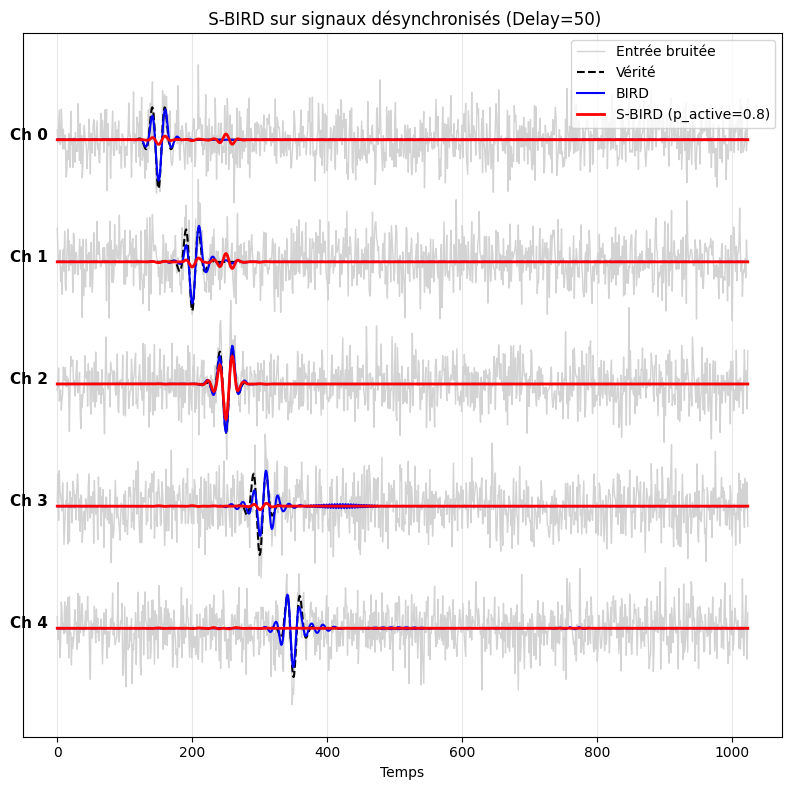

S-BIRD: Lambda=0.0878


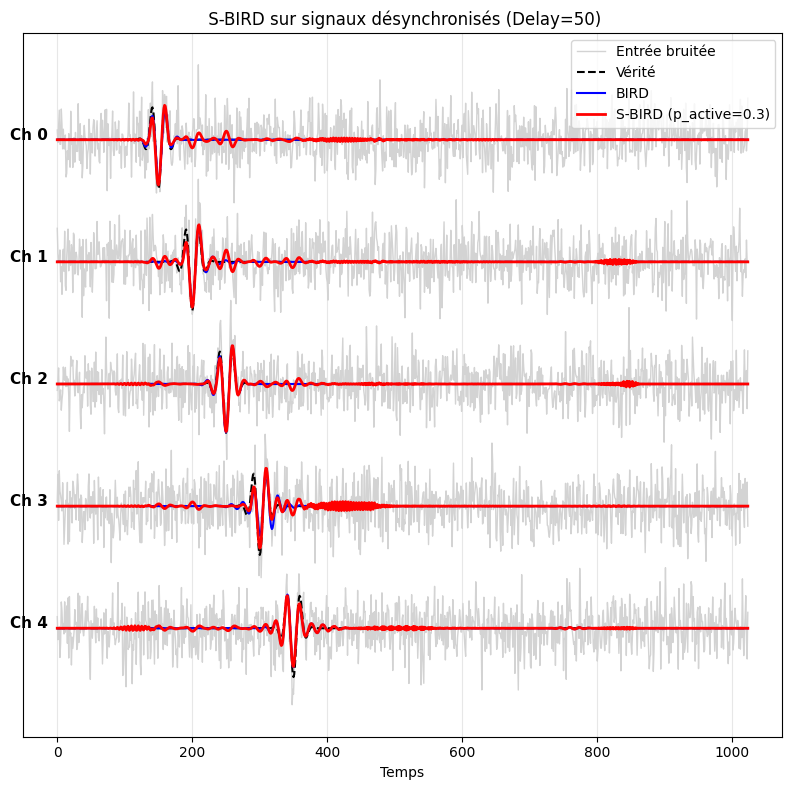

In [45]:
# Expérience 4 : désynchronisation, BIRD vs S-BIRD
np.random.seed(42)

# Signal de base : petite onde centrée vers t=150
N = 1024
n_channels = 5
scales = [32, 64, 128]
n_runs = 40

t = np.arange(N)
pulse = np.exp(-((t - 150)/15)**2) * np.cos(2*np.pi*0.05*t)
pulse = pulse / np.max(np.abs(pulse))

# On crée 5 canaux avec retard croissant
delay = 50
X_clean = np.zeros((n_channels, N))
for c in range(n_channels):
    X_clean[c] = np.roll(pulse, c * delay)

# On ajoute du bruit
SNR = 8
sigma = 10**(-SNR / 20.0)
noise = np.random.randn(n_channels, N) * sigma
X_noisy = X_clean + noise

print(f"Test désynchronisation : delay={delay} samples, SNR={SNR} dB")

# BIRD indépendant par canal
denoised_bird = bird(X_noisy, scales=scales, n_runs=n_runs, p_above=1e-5)
for p_active in [0.8, 0.3]:
    # S-BIRD structuré strict 
    denoised_sbird = sbird(X_noisy, scales=scales, n_runs=n_runs,
                        p_above=1e-5, p_active=p_active)

    # Plots
    plt.figure(figsize=(8, 8))
    plt.title(f" S-BIRD sur signaux désynchronisés (Delay={delay})")

    offset = 2.5
    for c in range(n_channels):
        base = -c * offset
        lbl_noise = "Entrée bruitée" if c == 0 else None
        lbl_clean = "Vérité" if c == 0 else None
        lbl_bird  = "BIRD" if c == 0 else None
        lbl_sbird = f"S-BIRD (p_active={p_active})" if c == 0 else None

        plt.plot(X_noisy[c] + base, color="lightgrey", lw=1, label=lbl_noise)
        plt.plot(X_clean[c] + base, "k--", lw=1.5, label=lbl_clean)
        plt.plot(denoised_bird[c] + base, "b", lw=1.5, label=lbl_bird)
        plt.plot(denoised_sbird[c] + base, "r", lw=2.0, label=lbl_sbird)

        plt.text(-70, base, f"Ch {c}", fontsize=11, fontweight="bold")

    plt.yticks([])
    plt.xlabel("Temps")
    plt.grid(alpha=0.3)
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()



### S-BIRD échoue ici alors que BIRD fonctionne !! 

Les signaux sont désynchronisé : le pulse n’est jamais présent au même instant sur les 5 canaux.

- BIRD traite chaque canal séparément. Il ne fait aucune hypothèse de synchronisation, donc il retrouve bien le pulse sur chaque capteur.

- S-BIRD, avec `p_active = 0.8`, impose un consensus total : pour activer un atome, il faut qu’il soit fort en même temps sur tous les canaux. Or, à cause du retard, quand un canal voit le pulse, les autres sont presque plats.S-BIRD interprète alors cette activité isolée comme du bruit local et l’écrase.

Ainsi, BIRD suit bien la vérité, tandis que S-BIRD restent presque à zéro.

Pour corriger ce comportement, il faudrait soit :
- baisser `p_active` pour accepter des pulses présents seulement sur une partie des capteurs ( c'est ce qu'on voit ici pour `p_active = 0.3` ca fontionne beaucoup mieux !)
- soit ré-aligner les canaux dans le temps avant d’appliquer S-BIRD.

Cette petite expérience montre que S-BIRD est très puissant si on respecte son modèle (synchronisation des canaux) mais dès qu’il y a des retards, il vaut mieux corriger la désynchronisation avant de lancer S-BIRD,  ou alors revenir à une approche plus locale (BIRD canal par canal).